In [ ]:
#Authors:
"""
Henry (Hua Hao) Qi
Ililli Terefe
Jaden Stanshall
Kartik Tyagi """




'\nHenry (Hua Hao) Qi\nIlilli Terefe\nJaden Stanshall\nKartik Tyagi '

In [ ]:
#Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import io
from google.colab import drive
from PIL import Image
import urllib.request
import torchvision.models
import random
import numpy as np
from torch.utils.data import DataLoader, Dataset
import time

In [ ]:
#Important Helper Functions
def plot_loss_curve(train_loss, valid_loss, num_epoch):   #takes two np arrays and 1 integer
    plt.title("Training vs Validation Loss")
    plt.plot(range(1, num_epoch + 1), train_loss, label = "Train")
    plt.plot(range(1, num_epoch + 1), valid_loss, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc = 'best')
    plt.show()

def plot_error_curve(train_error, valid_error, num_epoch):   #takes two np arrays and 1 integer
    plt.title("Training vs Validation Error")
    plt.plot(range(1, num_epoch + 1), train_error, label = "Train")
    plt.plot(range(1, num_epoch + 1), valid_error, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc = 'best')
    plt.show()

def plot_accuracy_curve(train_accuracy, valid_accuracy, num_epoch):   #takes two np arrays and 1 integer
    plt.title("Training vs Validation Accuracy")
    plt.plot(range(1, num_epoch + 1), train_accuracy, label = "Train")
    plt.plot(range(1, num_epoch + 1), valid_accuracy, label = "Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc = 'best')
    plt.show()

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

#function to find one-hot encoding:
def get_one_hot_encoding (label, num_classes):
    one_hot = np.zeros(num_classes)
    one_hot[int(label)] = 1
    return one_hot

def evaluate(net, loader, criterion):   #Returns validation error and loss values in this order
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        one_hot_label = [get_one_hot_encoding(labels[i],11) for i in range(len(labels))]
        one_hot_label = torch.tensor(np.array(one_hot_label))
        outputs = net(inputs)
        loss = criterion(outputs, one_hot_label)
        corr = outputs.argmax(dim=1) != one_hot_label.argmax(dim=1)
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(one_hot_label)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss
# def evaluate(net, loader, criterion,target_classes, num_epoch):
#     """ Evaluate the network on the validation set.

#      Args:
#          net: PyTorch neural network object
#          loader: PyTorch data loader for the validation set
#          criterion: The loss function
#      Returns:
#          err: A scalar for the avg classification error over the validation set
#          loss: A scalar for the average loss function over the validation set
#      """
#     total_loss = 0.0
#     total_err = 0.0
#     total_epoch = 0
#     for i, Data in enumerate(loader, 0):
#             # Get the inputs
#             inputs, labels = Data
#             one_hot_label = [get_one_hot_encoding(labels[0],5)]
#             one_hot_label = torch.tensor(one_hot_label, dtype=torch.float32)

#             outputs = net(inputs)
#             loss = criterion(outputs, one_hot_label)

#             corr = outputs.argmax(dim=1) != one_hot_label.argmax(dim=1)
#             total_err +=int(corr.sum())
#             total_loss+=loss.item()
#             total_epoch+= num_epoch
#     err = float(total_err) / total_epoch
#     loss = float(total_loss) / (i + 1)
#     return err, loss

def get_num_files(path):   #Returns total number of files in a directory
    sum = 0
    for i in os.listdir(path):
        sum += 1
    return sum

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
#Data Loading
#drive.mount('/content/drive')
#Uploaded the folder dataset to the Colab Notebooks folder in drive

In [ ]:
max_height = 200
max_width = 200

!git clone https://github.com/henryyqi/Weather_Data

trans = transforms.Compose([transforms.Resize((max_height,max_width)), transforms.ToTensor()])
# transformation applied to every image

dataset = datasets.ImageFolder(root='/content/Weather_Data/dataset', transform=trans)
# folder from which the dataset is made, plus the transformation applied

dataset_labelled = []
for i in dataset:
  dataset_labelled.append(i)

dataset_labelled_shuffled = dataset_labelled.copy()
random.shuffle(dataset_labelled_shuffled)

image, label = dataset_labelled_shuffled[0]

order = ["dew", "fogsmog", "frost", "glaze", "hail", "lightning", "rain", "rainbow", "rime", "sandstorm", "snow"]

data = dataset_labelled_shuffled

# test print
plt.imshow(image.permute(1,2,0))
print("Label =", order[label])

Cloning into 'Weather_Data'...
remote: Enumerating objects: 6688, done.
remote: Total 6688 (delta 0), reused 0 (delta 0), pack-reused 6688
Receiving objects: 100% (6688/6688), 569.11 MiB | 23.10 MiB/s, done.
Resolving deltas: 100% (169/169), done.
Updating files: 100% (6862/6862), done.


KeyboardInterrupt: ignored

In [ ]:
#Data Distribution and Balancing Distribution
num_dew = 0
num_fogsmog = 0
num_frost = 0
num_glaze = 0
num_hail = 0
num_lightning = 0
num_rain = 0
num_rainbow = 0
num_rime = 0
num_sandstorm = 0
num_snow = 0

dew_data = []
fogsmog_data = []
frost_data = []
glaze_data = []
hail_data = []
lightning_data = []
rain_data = []
rainbow_data =[]
rime_data = []
sandstorm_data = []
snow_data = []

for image, label in dataset_labelled_shuffled:
    if label == 0:
        dew_data.append((image, label))
        num_dew += 1
    if label == 1:
        fogsmog_data.append((image, label))
        num_fogsmog += 1
    if label == 2:
        frost_data.append((image, label))
        num_frost += 1
    if label == 3:
        glaze_data.append((image, label))
        num_glaze += 1
    if label == 4:
        hail_data.append((image, label))
        num_hail += 1
    if label == 5:
        lightning_data.append((image, label))
        num_lightning += 1
    if label == 6:
        rain_data.append((image, label))
        num_rain += 1
    if label == 7:
        rainbow_data.append((image, label))
        num_rainbow += 1
    if label == 8:
        rime_data.append((image, label))
        num_rime += 1
    if label == 9:
        sandstorm_data.append((image, label))
        num_sandstorm += 1
    if label == 10:
        snow_data.append((image, label))
        num_snow += 1

lightning_data = lightning_data*2
num_lightning *= 2

rain_data = rain_data*2
num_rain *= 2

rainbow_data = rainbow_data*3
num_rainbow *= 3

num_total = num_dew + num_fogsmog + num_frost + num_glaze + num_hail + num_lightning + num_rain + num_rainbow + num_rime + num_sandstorm + num_snow

print("Number of dew images are", num_dew)
print("Number of fogsmog images are", num_fogsmog)
print("Number of frost images are", num_frost)
print("Number of glaze images are", num_glaze)
print("Number of hail images are", num_hail)
print("Number of lightning images are", num_lightning)
print("Number of rain images are", num_rain)
print("Number of rainbow images are", num_rainbow)
print("Number of rime images are", num_rime)
print("Number of sandstorm images are", num_sandstorm)
print("Number of snow images are", num_snow)
print("Total number of images are", num_total)

Number of dew images are 698
Number of fogsmog images are 851
Number of frost images are 475
Number of glaze images are 639
Number of hail images are 591
Number of lightning images are 754
Number of rain images are 1052
Number of rainbow images are 696
Number of rime images are 1160
Number of sandstorm images are 692
Number of snow images are 621
Total number of images are 8229


In [ ]:
#Splitting the data

train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

#This produces a test ratio of 0.1

batch_size = 5

train_data = []
valid_data = []
test_data = []

total_files = len(dataset_labelled_shuffled)
train_files = int(train_ratio*total_files)
valid_files = int(valid_ratio*total_files)
test_files = total_files - train_files - valid_files
for j in range(train_files):
    train_data.append(dataset_labelled_shuffled[j])
for j in range(valid_files):
    valid_data.append(dataset_labelled_shuffled[j + train_files])
for j in range(test_files):
    test_data.append(dataset_labelled_shuffled[j + train_files + valid_files])

#Randomizing data
random.shuffle(train_data)
random.shuffle(valid_data)
random.shuffle(test_data)

In [ ]:
######Create DataLoaders#######

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        return image, label

# Create train DataLoader
train_dataset = CustomDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create validation DataLoader
valid_dataset = CustomDataset(valid_data)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Create test DataLoader
test_dataset = CustomDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


NameError: ignored

rime
dew
sandstorm
rainbow
fogsmog
snow
sandstorm
fogsmog
frost
rime
fogsmog
rime
glaze
snow
rime


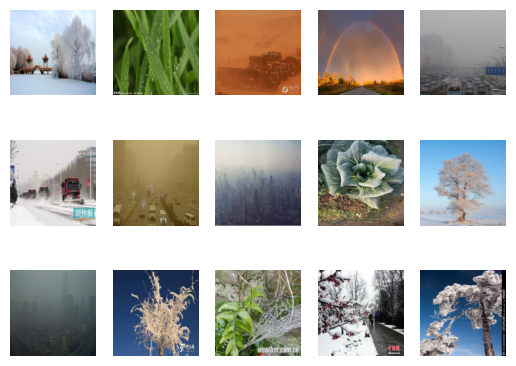

In [ ]:
####Visualize some images to test dataloaders
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    for image in images:
        # normalize pixel intensity values to [0, 1]
        img = image / 2 + 0.5
        plt.subplot(3, 5, k+1)
        plt.axis('off')
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        k += 1
    for label in labels:
        print(order[label])
    if k > 10:
        break

In [ ]:
#Baseline Model

#order = ["dew", "fogsmog", "frost", "glaze", "hail", "lightning", "rain", "rainbow", "rime", "sandstorm", "snow"]

class BaseLine1(nn.Module):
    def __init__(self):
        super(BaseLine1, self).__init__()
        self.encodings = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

    def forward(self, prev):
        random.shuffle(self.encodings)
        return torch.FloatTensor(self.encodings[0])

class BaseLine2(nn.Module):
    def __init__(self):
        super(BaseLine2, self).__init__()
        self.encodings = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
        self.total = num_total
        self.left = [num_dew, num_fogsmog, num_frost, num_glaze, num_hail, num_lightning, num_rain, num_rainbow, num_rime, num_sandstorm, num_snow]

    def forward(self, prev):
        probabilities = [self.left[0]/self.total, self.left[1]/self.total, self.left[2]/self.total, self.left[3]/self.total, self.left[4]/self.total, self.left[5]/self.total, self.left[6]/self.total, self.left[7]/self.total, self.left[8]/self.total, self.left[9]/self.total, self.left[10]/self.total]
        if prev >= 0:
            self.total -= 1
            self.left[prev] -= 1
            for i in range(11):
                probabilities[i] = probabilities[int(prev)]*(self.left[i]/self.total) + ((float(prev != i))*probabilities[i])
        max = 0
        index = 0
        for i in range(11):
            if probabilities[i] > max:
                max = probabilities[i]
                index = i
        return torch.FloatTensor(self.encodings[index])

class BaseLine3(nn.Module):
    def __init__(self):
        super(BaseLine3, self).__init__()
        self.encodings = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
        self.left = [num_dew, num_fogsmog, num_frost, num_glaze, num_hail, num_lightning, num_rain, num_rainbow, num_rime, num_sandstorm, num_snow]

    def forward(self, prev):
        if prev >= 0:
            self.left[prev] -= 1
        max = 0
        index = 0
        for i in range(11):
            if self.left[i] > max:
                max = self.left[i]
                index = i
        return torch.FloatTensor(self.encodings[index])

class BaseLine4(nn.Module):
    def __init__(self):
        super(BaseLine4, self).__init__()
        self.encodings = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                                   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
        self.left = [num_dew, num_fogsmog, num_frost, num_glaze, num_hail, num_lightning, num_rain, num_rainbow, num_rime, num_sandstorm, num_snow]

    def forward(self, prev):
        max = 0
        index = 0
        for i in range(11):
            if self.left[i] > max:
                max = self.left[i]
                index = i
        return torch.FloatTensor(self.encodings[index])

In [ ]:
def test_baseline(base, data):
    prev = -1
    total_correct = 0
    total_tested = 0
    for image, label in data:
        one_hot_label = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        one_hot_label[label] = 1
        one_hot_label = torch.tensor(one_hot_label, dtype=torch.float32)
        output = base(prev)
        prev = label
        same = True
        for i in range(11):
            if output[i] != one_hot_label[i]:
                same = False
                break
        total_tested += 1
        total_correct += int(same)
    accuracy = float(total_correct/total_tested)
    return accuracy

base1 = BaseLine1()
base2 = BaseLine2()
base3 = BaseLine3()
base4 = BaseLine4()

data_used = test_data_aug

print("First baseline model (random return) accuracy is", test_baseline(base1, data_used))
print("Second baseline model (highest probability return) accuracy is", test_baseline(base2, data_used))
print("Third baseline model (highest amount return) is", test_baseline(base3, data_used))
print("Fourth baseline model (most common return) is", test_baseline(base4, data_used))

First baseline model (random return) accuracy is 0.06880733944954129
Second baseline model (highest probability return) accuracy is 0.13761467889908258
Third baseline model (highest amount return) is 0.12729357798165136
Fourth baseline model (most common return) is 0.12729357798165136


In [ ]:
#Neural Network Model

#Max Height stored in max_height(3174) and Max Width stored in max_width(4863)

class WeatherNet(nn.Module):
    def __init__(self):
        super(WeatherNet, self).__init__()
        self.name = "WeatherNN"
        self.conv1 = nn.Conv2d(3, 16, 9)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 45, 9)
      #  self.conv3 = nn.Conv2d(16, 32, 9)
      #  self.conv4 = nn.Conv2d(16, 64, 3)
      #  self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(44 * 45 * 44, 250)
        self.fc2 = nn.Linear(250, 11)
      #  self.fc3 = nn.Linear(150, 11) # 11 classes in final output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
     #   x = self.pool(F.relu(self.conv3(x)))
     #   x = self.pool(F.relu(self.conv4(x)))

        x = x.view(-1, 44 * 45 * 44 )
        x = F.relu(self.fc1(x))
       # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
#Accuracy model

def get_accuracy(net, data):
    total_correct = 0
    total_tested = 0
    for input, label in data:
        one_hot_label = [get_one_hot_encoding(label[i],11) for i in range(len(label))]
        one_hot_label = torch.tensor(np.array(one_hot_label))
        outputs = net(input)
        corr = outputs.argmax(dim=1) == one_hot_label.argmax(dim=1)
        total_correct += int(corr.sum())
        total_tested += len(one_hot_label)
    accuracy = float(total_correct/total_tested)
    return accuracy

In [ ]:
#Training Results

#Training function
def train_net(net, batch_size=1, learning_rate=0.0001, num_epochs=1):
    ########################################################################
    # Train a classifier on weather
    target_classes = ["dew", "fogsmog", "frost", "glaze", "hail", "lightning", "rain", "rainbow", "rime", "sandstorm", "snow"]

    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy (CE).
    # Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    index = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, Data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = Data
            one_hot_label = [get_one_hot_encoding(labels[i],11) for i in range(len(labels))]
            one_hot_label = torch.tensor(one_hot_label, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, one_hot_label)
            loss.backward()
            optimizer.step()

            corr = outputs.argmax(dim=1) != one_hot_label.argmax(dim=1)
            total_train_err +=int(corr.sum())
            total_train_loss+=loss.item()
            total_epoch+= len(one_hot_label)

        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        train_acc[epoch] = get_accuracy(net, train_loader) # replace by 1-train_err[epoch] ?

        val_err[epoch], val_loss[epoch] = evaluate(net, valid_loader, criterion)
        val_acc[epoch] = get_accuracy(net, valid_loader)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    train_err = np.loadtxt("{}_train_err.csv".format(model_path))
    val_err = np.loadtxt("{}_val_err.csv".format(model_path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(model_path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(model_path))

    n = num_epochs # number of epochs
    plot_error_curve(train_err, val_err, n)
    plot_loss_curve(train_loss, val_loss, n)
    plot_accuracy_curve(train_acc, val_acc, n)

In [ ]:
Weather_net = WeatherNet()
train_net(Weather_net, num_epochs=25, learning_rate=0.00013)
print("Validation accuracy of model is", get_accuracy(Weather_net, valid_loader))

In [ ]:
print("Test accuracy of model is", get_accuracy(Weather_net, test_loader))

Test accuracy of model is 0.814935064935065


In [ ]:
print("Train accuracy of model is", get_accuracy(Weather_net, train_loader))

Train accuracy of model is 0.9496738117427772


link to external copy
https://colab.research.google.com/drive/1-Rz7I6_wwX8uUaKYWgxonZ7mfY0fZZPh?usp=sharing

In [ ]:
#*****************Training function2 (Adam optimizer)***************************
def get_one_hot_encoding_tensor(label, num_classes):
    one_hot_array = torch.zeros(label.shape[0], num_classes)
    one_hot_array.scatter_(1, label.unsqueeze(1), 1.0)
    return one_hot_array

def train_net_Adam2(net, batch_sz, learning_rate, num_epochs):
    ########################################################################
    # Train a classifier on weather
    target_classes = ["fogsmog", "lightning", "rain", "sandstorm", "snow"]

    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy (CE).
    # Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    """
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)"""

    train_err = []
    train_loss = []
    val_err = []
    val_loss = []

    train_acc = []
    val_acc = []

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_sz, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_sz, shuffle=False)
    #print(len(train_loader))
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, Data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = Data
            one_hot_label = get_one_hot_encoding_tensor(labels,5)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, one_hot_label)
            loss.backward()
            optimizer.step()

            corr = outputs.argmax(dim=1) != one_hot_label.argmax(dim=1)
            total_train_err +=int(corr.sum())
            total_train_loss+=loss.item()
            total_epoch+= len(one_hot_label)

        epoch_loss = float(total_train_loss) / (i+1)
        epoch_err = float(total_train_err) / total_epoch

        train_err.append (epoch_err)
        train_loss.append (epoch_loss)
        train_acc.append((1-epoch_err))

        val_er, val_ls = evaluate(net, valid_loader, criterion)
        val_err.append(val_er)
        val_loss.append(val_ls)
        val_acc.append((1-val_er))
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Error: {epoch_err:.4f}, "
            f"Validation Loss: {val_ls:.4f}, Validation Error: {val_er:.4f}")

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_sz, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    train_err = np.loadtxt("{}_train_err.csv".format(model_path))
    val_err = np.loadtxt("{}_val_err.csv".format(model_path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(model_path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(model_path))

    n = num_epochs # number of epochs
    plot_error_curve(train_err, val_err, n)
    plot_loss_curve(train_loss, val_loss, n)
    plot_accuracy_curve(train_acc, val_acc, n)

Epoch 1/25, Train Loss: 0.9898, Train Error: 0.4063, Validation Loss: 0.6418, Validation Error: 0.2496
Epoch 2/25, Train Loss: 0.5702, Train Error: 0.2176, Validation Loss: 0.8491, Validation Error: 0.3148
Epoch 3/25, Train Loss: 0.5244, Train Error: 0.1966, Validation Loss: 0.5092, Validation Error: 0.1925
Epoch 4/25, Train Loss: 0.4976, Train Error: 0.1827, Validation Loss: 0.6256, Validation Error: 0.2316
Epoch 5/25, Train Loss: 0.4476, Train Error: 0.1580, Validation Loss: 0.6206, Validation Error: 0.2398
Epoch 6/25, Train Loss: 0.4369, Train Error: 0.1547, Validation Loss: 0.4595, Validation Error: 0.1762
Epoch 7/25, Train Loss: 0.4052, Train Error: 0.1361, Validation Loss: 0.4519, Validation Error: 0.1909
Epoch 8/25, Train Loss: 0.3789, Train Error: 0.1319, Validation Loss: 0.8974, Validation Error: 0.2936
Epoch 9/25, Train Loss: 0.4069, Train Error: 0.1421, Validation Loss: 0.5005, Validation Error: 0.1860
Epoch 10/25, Train Loss: 0.3204, Train Error: 0.1123, Validation Loss: 0.

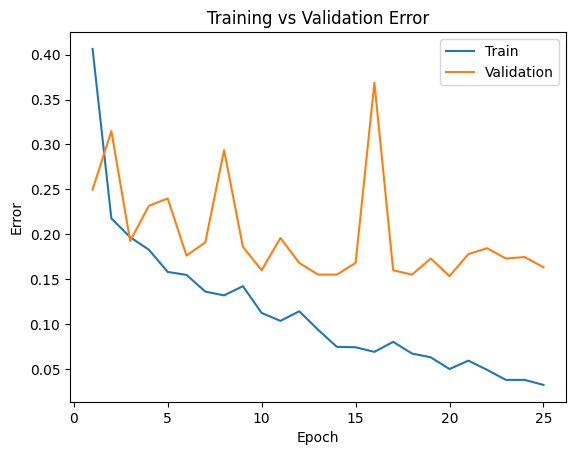

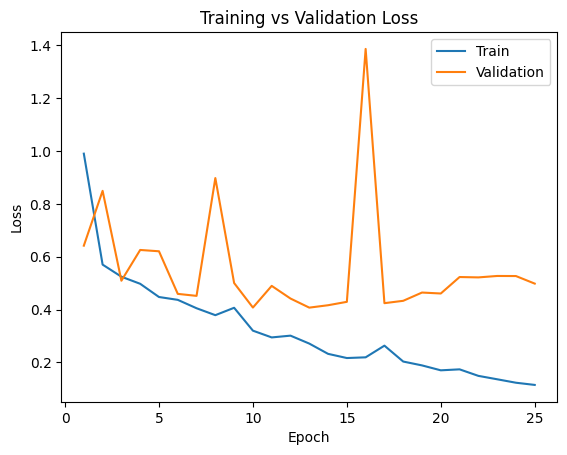

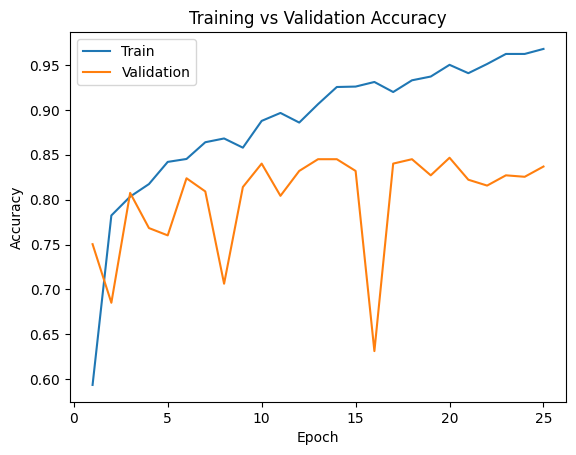

In [ ]:
Weather_net_Adam2 = WeatherNet()
train_net_Adam2(Weather_net_Adam2, 32, 8e-5, 25)

Epoch 1/10, Train Loss: 0.8392, Train Error: 0.3332, Validation Loss: 0.6284, Validation Error: 0.2577
Epoch 2/10, Train Loss: 0.5356, Train Error: 0.1999, Validation Loss: 0.5393, Validation Error: 0.2088
Epoch 3/10, Train Loss: 0.4712, Train Error: 0.1696, Validation Loss: 0.4819, Validation Error: 0.1778
Epoch 4/10, Train Loss: 0.4386, Train Error: 0.1678, Validation Loss: 0.4773, Validation Error: 0.1615
Epoch 5/10, Train Loss: 0.4038, Train Error: 0.1393, Validation Loss: 0.4591, Validation Error: 0.1631
Epoch 6/10, Train Loss: 0.3566, Train Error: 0.1314, Validation Loss: 0.4632, Validation Error: 0.1729
Epoch 7/10, Train Loss: 0.3199, Train Error: 0.1165, Validation Loss: 0.4920, Validation Error: 0.1664
Epoch 8/10, Train Loss: 0.3085, Train Error: 0.1100, Validation Loss: 0.4747, Validation Error: 0.1762
Epoch 9/10, Train Loss: 0.2877, Train Error: 0.1044, Validation Loss: 0.4517, Validation Error: 0.1631
Epoch 10/10, Train Loss: 0.2687, Train Error: 0.0895, Validation Loss: 0.

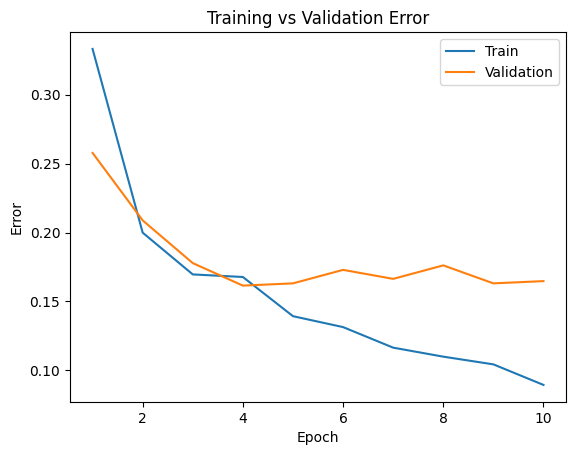

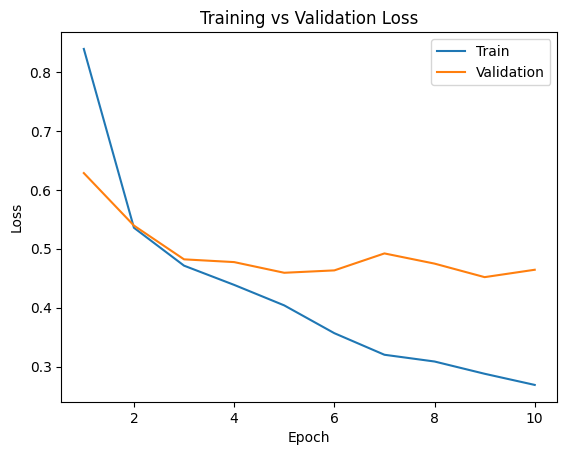

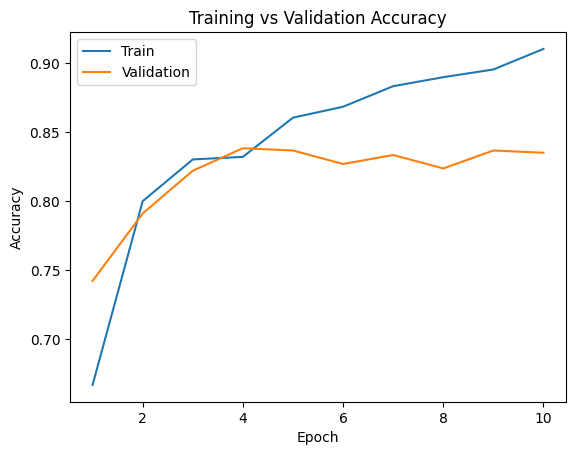

0.8955954323001631
0.9285714285714286


In [ ]:
Weather_net_Adam3 = WeatherNet()
train_loader_temp = DataLoader(train_dataset_aug, 15, shuffle=False)
train_net_Adam_Augmented(Weather_net_Adam3, 15, 6e-5, 10, order)

Epoch 1/10, Train Loss: 0.9322, Train Error: 0.3705, Validation Loss: 0.6433, Validation Error: 0.2463
Epoch 2/10, Train Loss: 0.5966, Train Error: 0.2237, Validation Loss: 0.6732, Validation Error: 0.2398
Epoch 3/10, Train Loss: 0.4994, Train Error: 0.1869, Validation Loss: 0.5242, Validation Error: 0.2039
Epoch 4/10, Train Loss: 0.4501, Train Error: 0.1650, Validation Loss: 0.4821, Validation Error: 0.1941
Epoch 5/10, Train Loss: 0.4243, Train Error: 0.1486, Validation Loss: 0.4710, Validation Error: 0.1713
Epoch 6/10, Train Loss: 0.4065, Train Error: 0.1477, Validation Loss: 0.4588, Validation Error: 0.1746
Epoch 7/10, Train Loss: 0.4321, Train Error: 0.1566, Validation Loss: 0.4518, Validation Error: 0.1746
Epoch 8/10, Train Loss: 0.3757, Train Error: 0.1314, Validation Loss: 0.4383, Validation Error: 0.1599
Epoch 9/10, Train Loss: 0.3293, Train Error: 0.1221, Validation Loss: 0.4548, Validation Error: 0.1615
Epoch 10/10, Train Loss: 0.3149, Train Error: 0.1142, Validation Loss: 0.

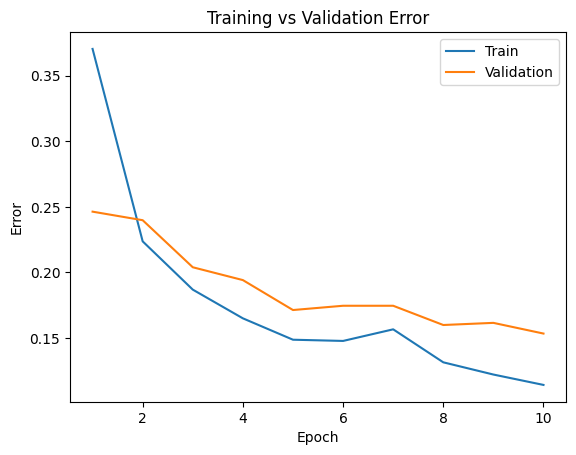

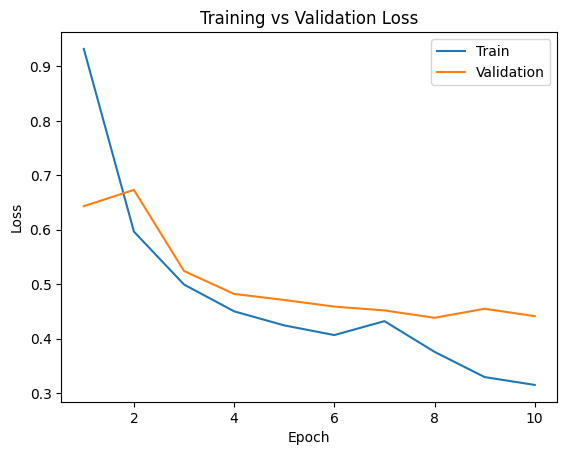

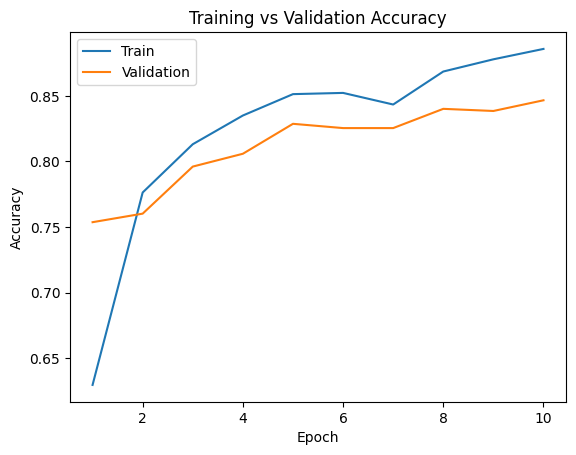

Validation Accuracy of this model is 0.061224489795918366
Testing Accuracy of this model is 0.06986899563318777


In [ ]:
Weather_net_Adam3 = WeatherNet()
train_loader_temp = DataLoader(train_dataset_aug, 15, shuffle=False)
train_net_Adam_Augmented(Weather_net_Adam3, 15, 6e-5, 10, order)
valid_loader_temp = DataLoader(valid_dataset_aug, 32, shuffle=False)
print("Validation Accuracy of this model is", get_accuracy(Weather_net_Adam3, valid_loader_temp))
test_loader_temp = DataLoader(test_dataset_aug, 32, shuffle=False)
print("Testing Accuracy of this model is", get_accuracy(Weather_net_Adam3, test_loader_temp))

In [ ]:
valid_loader_temp = DataLoader(valid_dataset_aug, 32, shuffle=False)
print("Validation Accuracy of this model is", get_accuracy(Weather_net_Adam3, valid_loader_temp))
test_loader_temp = DataLoader(test_dataset_aug, 32, shuffle=False)
print("Testing Accuracy of this model is", get_accuracy(Weather_net_Adam3, test_loader_temp))

Validation Accuracy of this model is 0.8466557911908646
Testing Accuracy of this model is 0.8214285714285714


Epoch 1/25, Train Loss: 1.6363, Train Error: 0.5432, Validation Loss: 1.3428, Validation Error: 0.4218
Epoch 2/25, Train Loss: 1.1610, Train Error: 0.3759, Validation Loss: 1.0889, Validation Error: 0.3586
Epoch 3/25, Train Loss: 0.9965, Train Error: 0.3206, Validation Loss: 1.0658, Validation Error: 0.3638
Epoch 4/25, Train Loss: 0.9013, Train Error: 0.2950, Validation Loss: 1.0097, Validation Error: 0.3431
Epoch 5/25, Train Loss: 0.8339, Train Error: 0.2669, Validation Loss: 0.9414, Validation Error: 0.3167
Epoch 6/25, Train Loss: 0.7614, Train Error: 0.2426, Validation Loss: 0.9338, Validation Error: 0.3057
Epoch 7/25, Train Loss: 0.7041, Train Error: 0.2175, Validation Loss: 0.8891, Validation Error: 0.2954
Epoch 8/25, Train Loss: 0.6335, Train Error: 0.1962, Validation Loss: 0.8850, Validation Error: 0.2931
Epoch 9/25, Train Loss: 0.5713, Train Error: 0.1743, Validation Loss: 0.9602, Validation Error: 0.3218
Epoch 10/25, Train Loss: 0.5448, Train Error: 0.1692, Validation Loss: 0.

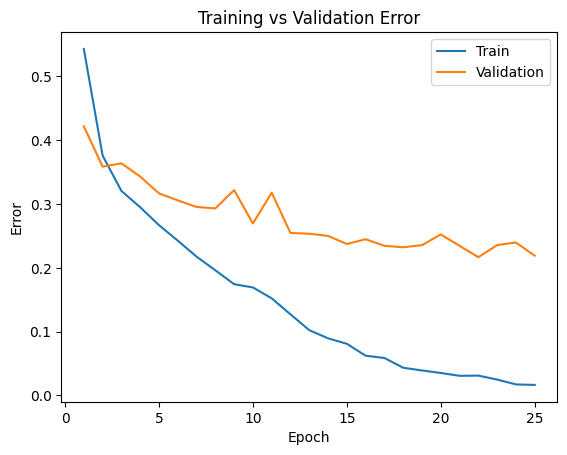

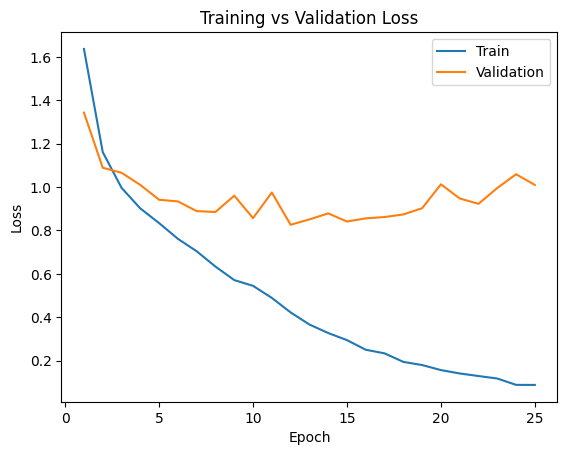

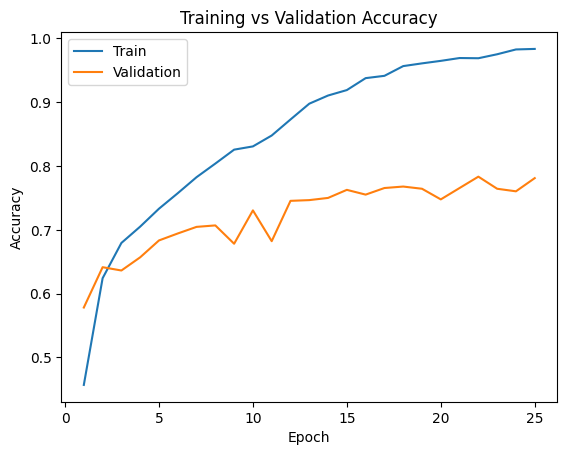

Validation Accuracy of this model is 0.7810344827586206
Testing Accuracy of this model is 0.7935779816513762


In [ ]:
Weather_net_Adam4 = WeatherNet()
train_loader_temp = DataLoader(train_dataset_aug, 64, shuffle=False)
train_net_Adam_Augmented(Weather_net_Adam4, 64, 8e-5, 25, order)
valid_loader_temp = DataLoader(valid_dataset_aug, 64, shuffle=False)
print("Validation Accuracy of this model is", get_accuracy(Weather_net_Adam4, valid_loader_temp))
test_loader_temp = DataLoader(test_dataset_aug, 1, shuffle=False)
print("Testing Accuracy of this model is", get_accuracy(Weather_net_Adam4, test_loader_temp))

In [ ]:
class BaseLine5(nn.Module):
    def __init__(self):
        super(BaseLine5, self).__init__()
        self.layer1 = nn.Linear(200*200*3, 500)
        self.layer2 = nn.Linear(500, 11)
    def forward(self, x):
        x = x.view(-1, 200*200*3)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

base_ann = BaseLine5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_ann.parameters(), lr=0.0001, momentum=0.9)

train_loader_temp = DataLoader(train_dataset_aug, 64, shuffle=False)
test_loader_temp = DataLoader(test_dataset_aug, 1, shuffle=False)

for epoch in range(5):
    for data, label in train_loader_temp:
        one_hot_label = [get_one_hot_encoding(label[i],11) for i in range(len(label))]
        one_hot_label = torch.tensor(np.array(one_hot_label))
        outputs = base_ann(data)
        loss = criterion(outputs, one_hot_label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

print("ANN Baseline accuracy over test data is", get_accuracy(base_ann, test_loader_temp))

ANN Baseline accuracy over test data is 0.4461009174311927


In [ ]:
valid_loader = DataLoader(valid_dataset, 32, shuffle=False)
get_accuracy(Weather_net_Adam2, valid_loader)

0.8548123980424144

In [ ]:
test_loader = DataLoader(test_dataset, 32, shuffle=False)
get_accuracy(Weather_net_Adam2, test_loader)

0.8181818181818182

Epoch 1/25, Train Loss: 1.0264, Train Error: 0.4007, Validation Loss: 0.6919, Validation Error: 0.2561
Epoch 2/25, Train Loss: 0.6423, Train Error: 0.2465, Validation Loss: 0.5458, Validation Error: 0.1941
Epoch 3/25, Train Loss: 0.5479, Train Error: 0.1943, Validation Loss: 0.6013, Validation Error: 0.2398
Epoch 4/25, Train Loss: 0.4846, Train Error: 0.1743, Validation Loss: 0.4786, Validation Error: 0.1713
Epoch 5/25, Train Loss: 0.4366, Train Error: 0.1566, Validation Loss: 0.5105, Validation Error: 0.1892
Epoch 6/25, Train Loss: 0.4213, Train Error: 0.1496, Validation Loss: 0.4484, Validation Error: 0.1762
Epoch 7/25, Train Loss: 0.3854, Train Error: 0.1389, Validation Loss: 0.4252, Validation Error: 0.1468
Epoch 8/25, Train Loss: 0.3826, Train Error: 0.1375, Validation Loss: 0.4342, Validation Error: 0.1533
Epoch 9/25, Train Loss: 0.3472, Train Error: 0.1193, Validation Loss: 0.4291, Validation Error: 0.1713
Epoch 10/25, Train Loss: 0.3464, Train Error: 0.1212, Validation Loss: 0.

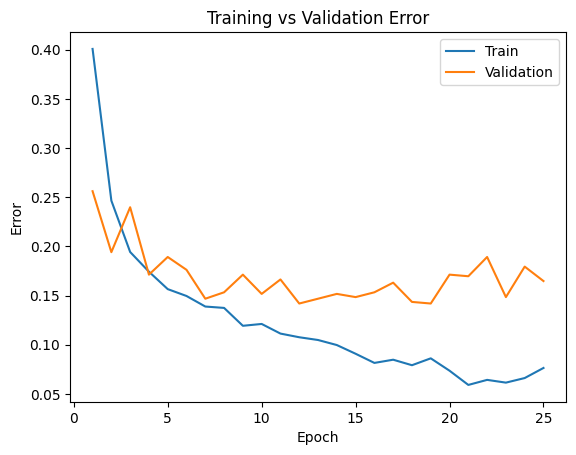

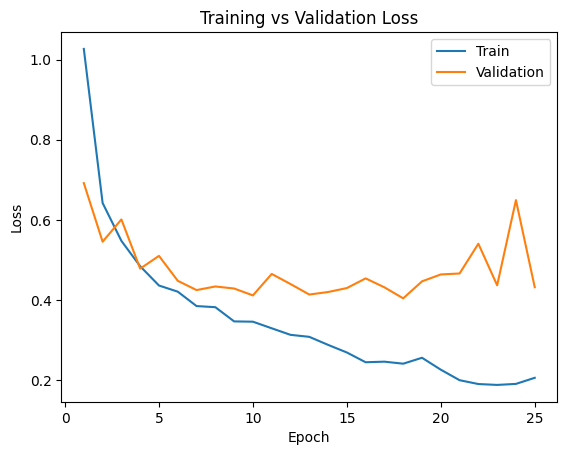

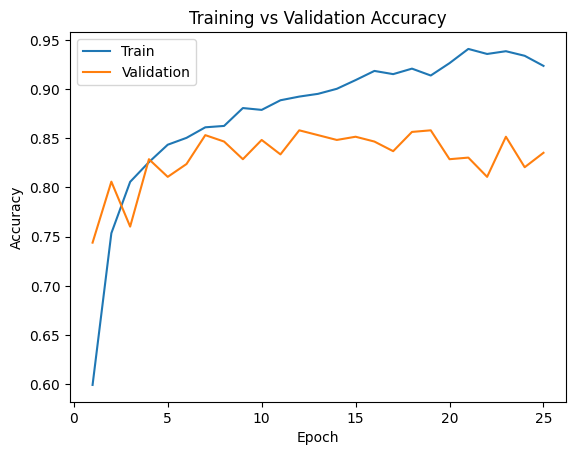

In [ ]:
###########Increase batch size#############################################################
Weather_net_Adam = WeatherNet()
train_net_Adam2(Weather_net_Adam, 64, 8e-5, 25)

In [ ]:
valid_loader = DataLoader(valid_dataset, 64, shuffle=False)
get_accuracy(Weather_net_Adam, valid_loader)

0.8548123980424144

In [ ]:
test_loader = DataLoader(test_dataset, 64, shuffle=False)
get_accuracy(Weather_net_Adam, test_loader)

0.8344155844155844

Epoch 1/25, Train Loss: 0.9416, Train Error: 0.3630, Validation Loss: 0.5902, Validation Error: 0.2219
Epoch 2/25, Train Loss: 0.5788, Train Error: 0.2260, Validation Loss: 0.5033, Validation Error: 0.1729
Epoch 3/25, Train Loss: 0.5167, Train Error: 0.1920, Validation Loss: 0.6529, Validation Error: 0.2675
Epoch 4/25, Train Loss: 0.4602, Train Error: 0.1678, Validation Loss: 0.5109, Validation Error: 0.1974
Epoch 5/25, Train Loss: 0.4459, Train Error: 0.1622, Validation Loss: 0.4716, Validation Error: 0.1631
Epoch 6/25, Train Loss: 0.4037, Train Error: 0.1454, Validation Loss: 0.4280, Validation Error: 0.1615
Epoch 7/25, Train Loss: 0.3748, Train Error: 0.1342, Validation Loss: 0.4263, Validation Error: 0.1419
Epoch 8/25, Train Loss: 0.3833, Train Error: 0.1384, Validation Loss: 0.4973, Validation Error: 0.1827
Epoch 9/25, Train Loss: 0.3518, Train Error: 0.1202, Validation Loss: 0.4070, Validation Error: 0.1468
Epoch 10/25, Train Loss: 0.3218, Train Error: 0.1160, Validation Loss: 0.

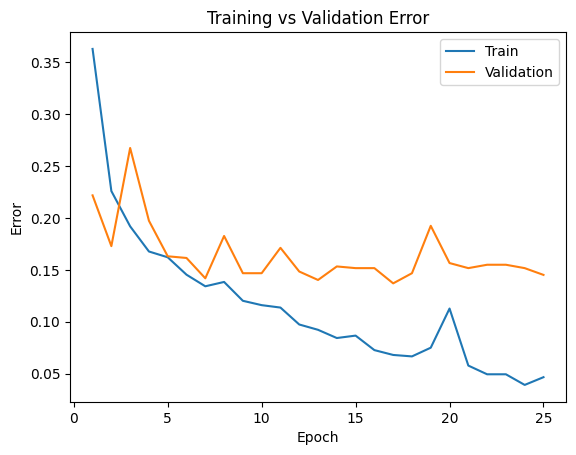

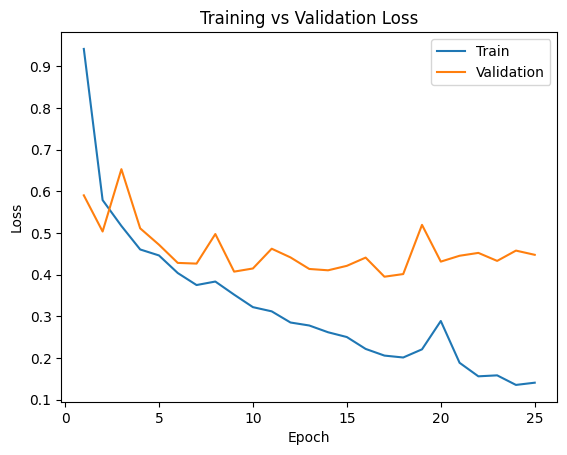

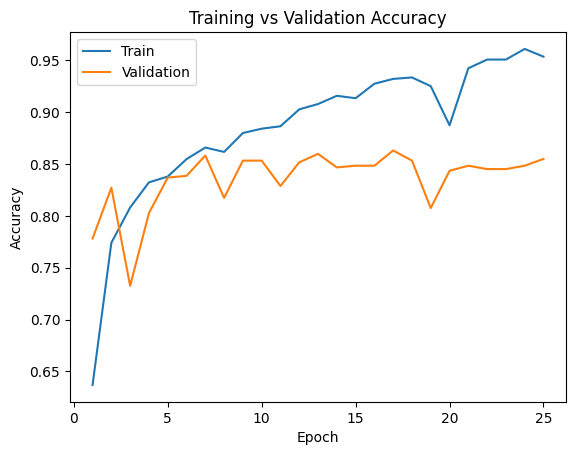

In [ ]:
###########Increase learning rate#########################
Weather_net_Adam = WeatherNet()
train_net_Adam2(Weather_net_Adam, 64, 1e-4, 25)

Epoch 1/14, Train Loss: 0.9379, Train Error: 0.3602, Validation Loss: 0.6570, Validation Error: 0.2219
Epoch 2/14, Train Loss: 0.5903, Train Error: 0.2241, Validation Loss: 0.5927, Validation Error: 0.2431
Epoch 3/14, Train Loss: 0.5164, Train Error: 0.1864, Validation Loss: 0.5164, Validation Error: 0.1794
Epoch 4/14, Train Loss: 0.4712, Train Error: 0.1682, Validation Loss: 0.4772, Validation Error: 0.1729
Epoch 5/14, Train Loss: 0.4873, Train Error: 0.1878, Validation Loss: 0.4935, Validation Error: 0.1550
Epoch 6/14, Train Loss: 0.3983, Train Error: 0.1431, Validation Loss: 0.4403, Validation Error: 0.1436
Epoch 7/14, Train Loss: 0.3622, Train Error: 0.1305, Validation Loss: 0.4103, Validation Error: 0.1256
Epoch 8/14, Train Loss: 0.3622, Train Error: 0.1319, Validation Loss: 0.4816, Validation Error: 0.1762
Epoch 9/14, Train Loss: 0.3335, Train Error: 0.1170, Validation Loss: 0.4481, Validation Error: 0.1419
Epoch 10/14, Train Loss: 0.3298, Train Error: 0.1123, Validation Loss: 0.

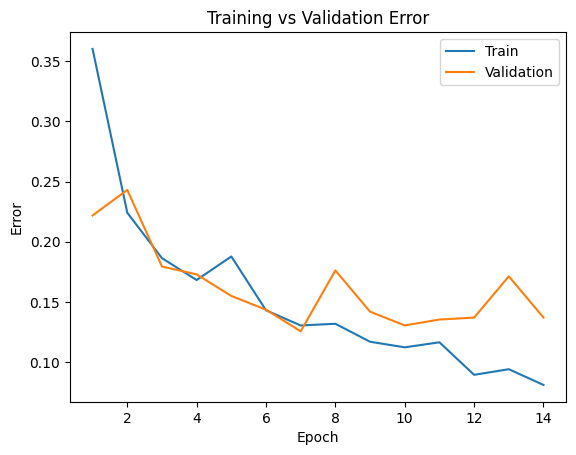

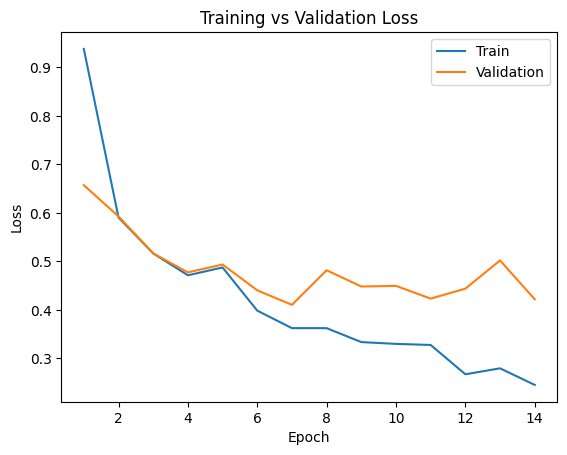

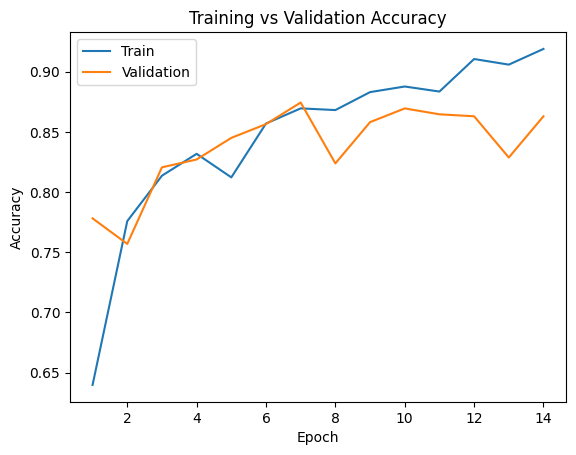

In [ ]:
Weather_net_best = WeatherNet()
train_net_Adam2(Weather_net_best, 32, 8e-5, 14)

In [ ]:
valid_loader = DataLoader(valid_dataset, 32, shuffle=False)
get_accuracy(Weather_net_best, valid_loader)

0.8629690048939641

In [ ]:
test_loader = DataLoader(test_dataset, 32, shuffle=False)
get_accuracy(Weather_net_best, test_loader)

0.8571428571428571

In [ ]:
#*********************************************************************************************************************************************************************************

Number of dew images are 698
Number of fogsmog images are 851
Number of frost images are 950
Number of glaze images are 639
Number of hail images are 591
Number of lightning images are 754
Number of rain images are 1052
Number of rainbow images are 696
Number of rime images are 1160
Number of sandstorm images are 692
Number of snow images are 621
Total number of images are 8704
Label = fogsmog


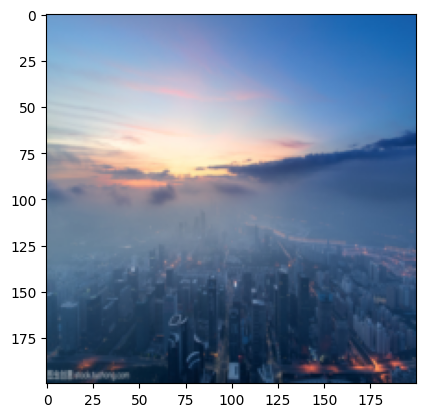

In [ ]:
#Augment data and increase output class#######################################

#perform data augmentation##########################
max_height = 200
max_width = 200


trans = transforms.Compose([transforms.Resize((max_height,max_width)), transforms.ToTensor()])
# transformation applied to every image
data_transforms = transforms.Compose([
    transforms.Resize((max_height,max_width)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

dataset_aug = datasets.ImageFolder(root='/content/Weather_Data/dataset', transform=trans)
# folder from which the dataset is made, plus the transformation applied

dataset_aug_labelled = []
for i in dataset_aug:
  dataset_aug_labelled.append(i)

dataset_aug_labelled_shuffled = dataset_aug_labelled.copy()
random.shuffle(dataset_aug_labelled_shuffled)

image, label = dataset_aug_labelled_shuffled[0]

order = ["dew", "fogsmog", "frost", "glaze", "hail", "lightning", "rain", "rainbow", "rime", "sandstorm", "snow"]

data_aug = dataset_aug_labelled_shuffled

#Balancing Data

#Data Distribution and Balancing Distribution
num_dew = 0
num_fogsmog = 0
num_frost = 0
num_glaze = 0
num_hail = 0
num_lightning = 0
num_rain = 0
num_rainbow = 0
num_rime = 0
num_sandstorm = 0
num_snow = 0

dew_data = []
fogsmog_data = []
frost_data = []
glaze_data = []
hail_data = []
lightning_data = []
rain_data = []
rainbow_data =[]
rime_data = []
sandstorm_data = []
snow_data = []

for image, label in dataset_aug_labelled_shuffled:
    if label == 0:
        dew_data.append((image, label))
        num_dew += 1
    if label == 1:
        fogsmog_data.append((image, label))
        num_fogsmog += 1
    if label == 2:
        frost_data.append((image, label))
        num_frost += 1
    if label == 3:
        glaze_data.append((image, label))
        num_glaze += 1
    if label == 4:
        hail_data.append((image, label))
        num_hail += 1
    if label == 5:
        lightning_data.append((image, label))
        num_lightning += 1
    if label == 6:
        rain_data.append((image, label))
        num_rain += 1
    if label == 7:
        rainbow_data.append((image, label))
        num_rainbow += 1
    if label == 8:
        rime_data.append((image, label))
        num_rime += 1
    if label == 9:
        sandstorm_data.append((image, label))
        num_sandstorm += 1
    if label == 10:
        snow_data.append((image, label))
        num_snow += 1

lightning_data = lightning_data*2
num_lightning *= 2

rain_data = rain_data*2
num_rain *= 2

rainbow_data = rainbow_data*3
num_rainbow *= 3

frost_data = frost_data*2
num_frost *= 2

num_total = num_dew + num_fogsmog + num_frost + num_glaze + num_hail + num_lightning + num_rain + num_rainbow + num_rime + num_sandstorm + num_snow
dataset_aug_labelled_shuffled = dew_data + fogsmog_data + frost_data + glaze_data + hail_data + lightning_data + rain_data + rainbow_data + rime_data + sandstorm_data + snow_data
random.shuffle(dataset_aug_labelled_shuffled)
random.shuffle(dataset_aug_labelled_shuffled)

print("Number of dew images are", num_dew)
print("Number of fogsmog images are", num_fogsmog)
print("Number of frost images are", num_frost)
print("Number of glaze images are", num_glaze)
print("Number of hail images are", num_hail)
print("Number of lightning images are", num_lightning)
print("Number of rain images are", num_rain)
print("Number of rainbow images are", num_rainbow)
print("Number of rime images are", num_rime)
print("Number of sandstorm images are", num_sandstorm)
print("Number of snow images are", num_snow)
print("Total number of images are", num_total)

# test print
plt.imshow(image.permute(1,2,0))
print("Label =", order[label])

#Splitting the data

train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

#This produces a test ratio of 0.1

train_data_aug = []
valid_data_aug = []
test_data_aug = []

total_files = len(dataset_aug_labelled_shuffled)
train_files = int(train_ratio*total_files)
valid_files = int(valid_ratio*total_files)
test_files = total_files - train_files - valid_files
for j in range(train_files):
    train_data_aug.append(dataset_aug_labelled_shuffled[j])
for j in range(valid_files):
    valid_data_aug.append(dataset_aug_labelled_shuffled[j + train_files])
for j in range(test_files):
    test_data_aug.append(dataset_aug_labelled_shuffled[j + train_files + valid_files])

#Randomizing data
random.shuffle(train_data_aug)
random.shuffle(valid_data_aug)
random.shuffle(test_data_aug)


In [ ]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        return image, label

train_dataset_aug = CustomDataset(train_data_aug)
valid_dataset_aug = CustomDataset(valid_data_aug)
test_dataset_aug = CustomDataset(test_data_aug)

In [ ]:
def train_net_Adam_Augmented(net, batch_sz, learning_rate, num_epochs, order):
    ########################################################################
    # Train a classifier on weather
    target_classes = order

    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy (CE).
    # Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = []
    train_loss = []
    val_err = []
    val_loss = []

    train_acc = []
    val_acc = []

    # Create dataloaders
    train_loader = DataLoader(train_dataset_aug, batch_sz, shuffle=True)
    valid_loader = DataLoader(valid_dataset_aug, batch_sz, shuffle=False)
    #print(len(train_loader))
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, Data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = Data
            one_hot_label = get_one_hot_encoding_tensor(labels,11)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, one_hot_label)
            loss.backward()
            optimizer.step()

            corr = outputs.argmax(dim=1) != one_hot_label.argmax(dim=1)
            total_train_err +=int(corr.sum())
            total_train_loss+=loss.item()
            total_epoch+= len(one_hot_label)

        epoch_loss = float(total_train_loss) / (i+1)
        epoch_err = float(total_train_err) / total_epoch

        train_err.append (epoch_err)
        train_loss.append (epoch_loss)
        train_acc.append((1-epoch_err))

        val_er, val_ls = evaluate(net, valid_loader, criterion)
        val_err.append(val_er)
        val_loss.append(val_ls)
        val_acc.append((1-val_er))
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Error: {epoch_err:.4f}, "
            f"Validation Loss: {val_ls:.4f}, Validation Error: {val_er:.4f}")

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_sz, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    train_err = np.loadtxt("{}_train_err.csv".format(model_path))
    val_err = np.loadtxt("{}_val_err.csv".format(model_path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(model_path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(model_path))

    n = num_epochs # number of epochs
    plot_error_curve(train_err, val_err, n)
    plot_loss_curve(train_loss, val_loss, n)
    plot_accuracy_curve(train_acc, val_acc, n)

Epoch 1/25, Train Loss: 0.8879, Train Error: 0.3500, Validation Loss: 0.7730, Validation Error: 0.2936
Epoch 2/25, Train Loss: 0.6211, Train Error: 0.2297, Validation Loss: 0.6079, Validation Error: 0.2398
Epoch 3/25, Train Loss: 0.5445, Train Error: 0.1957, Validation Loss: 0.7604, Validation Error: 0.3165
Epoch 4/25, Train Loss: 0.5095, Train Error: 0.1859, Validation Loss: 0.5054, Validation Error: 0.1958
Epoch 5/25, Train Loss: 0.4584, Train Error: 0.1608, Validation Loss: 0.5690, Validation Error: 0.2268
Epoch 6/25, Train Loss: 0.4071, Train Error: 0.1468, Validation Loss: 0.5128, Validation Error: 0.1941
Epoch 7/25, Train Loss: 0.3677, Train Error: 0.1300, Validation Loss: 0.4329, Validation Error: 0.1697
Epoch 8/25, Train Loss: 0.3633, Train Error: 0.1226, Validation Loss: 0.4961, Validation Error: 0.1876
Epoch 9/25, Train Loss: 0.3572, Train Error: 0.1263, Validation Loss: 0.4553, Validation Error: 0.1566
Epoch 10/25, Train Loss: 0.3054, Train Error: 0.1090, Validation Loss: 0.

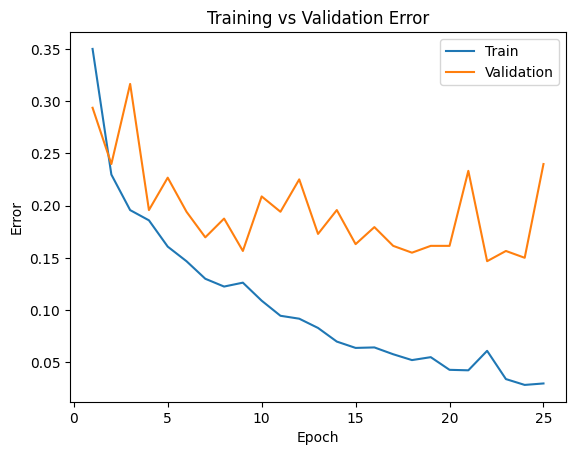

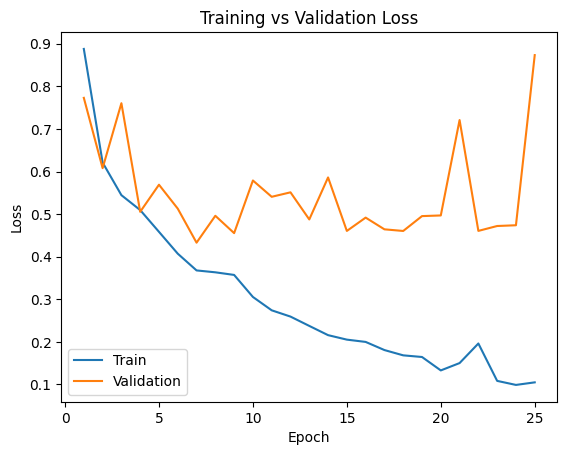

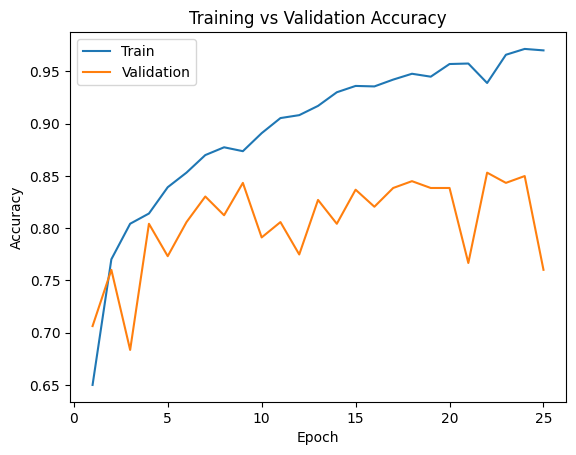

In [ ]:
Weather_net_best_aug = WeatherNet() # train with augmented data
train_net_Adam_Augmented(Weather_net_best_aug, 32, 9e-5, 25, order)


In [ ]:
test_loader_aug = DataLoader(test_dataset_aug, 32, shuffle=False)
Weather_net_best_aug_Epoch21 = WeatherNet()
Weather_net_best_aug_Epoch21.load_state_dict(torch.load('/content/model_WeatherNN_bs32_lr9e-05_epoch21')) # replace with path to best trained model
get_accuracy(Weather_net_best_aug_Epoch21, test_loader_aug)

0.8409090909090909

In [ ]:
valid_loader_aug = DataLoader(valid_dataset_aug, 32, shuffle=False)
get_accuracy(Weather_net_best_aug, valid_loader_aug)

In [ ]:
Weather_net_best_aug = WeatherNet() # train with augmented data
train_net_Adam_Augmented(Weather_net_best_aug, 32, 1e-4, 25, order)

Epoch 1/25, Train Loss: 0.8460, Train Error: 0.3350, Validation Loss: 0.7010, Validation Error: 0.2577
Epoch 2/25, Train Loss: 0.5735, Train Error: 0.2158, Validation Loss: 0.5945, Validation Error: 0.2170
Epoch 3/25, Train Loss: 0.5102, Train Error: 0.1887, Validation Loss: 0.6589, Validation Error: 0.2838
Epoch 4/25, Train Loss: 0.4575, Train Error: 0.1705, Validation Loss: 0.4829, Validation Error: 0.1892
Epoch 5/25, Train Loss: 0.4299, Train Error: 0.1449, Validation Loss: 0.6135, Validation Error: 0.2349
Epoch 6/25, Train Loss: 0.4121, Train Error: 0.1435, Validation Loss: 0.4832, Validation Error: 0.1811
Epoch 7/25, Train Loss: 0.3232, Train Error: 0.1104, Validation Loss: 0.4917, Validation Error: 0.1892
Epoch 8/25, Train Loss: 0.3362, Train Error: 0.1142, Validation Loss: 0.4522, Validation Error: 0.1680
Epoch 9/25, Train Loss: 0.3109, Train Error: 0.1025, Validation Loss: 0.4717, Validation Error: 0.1794


In [ ]:
Weather_net_best_aug = WeatherNet()
train_loader_temp = DataLoader(train_dataset_aug, 15, shuffle=False)
train_net_Adam_Augmented(Weather_net_Adam3, 15, 6e-5, 10, order)

In [ ]:
"""
#Modify output layer to 11 classes
WeatherNet_11_classes = WeatherNet()
WeatherNet_11_classes.load_state_dict(torch.load('/content/model_WeatherNN_bs32_lr8e-05_epoch4')) # replace with path to best trained model

in_features = WeatherNet_11_classes.fc2.in_features
num_classes_new = 11  # The new number of classes
WeatherNet_11_classes.fc2 = nn.Linear(in_features, num_classes_new)  # Replace the last layer with a new one

#initialize final layer weights
WeatherNet_11_classes.fc2.weight.data.normal (0, 0.01)
WeatherNet_11_classes.fc2.bias.data.zero_()
"""

"\n#Modify output layer to 11 classes\nWeatherNet_11_classes = WeatherNet()\nWeatherNet_11_classes.load_state_dict(torch.load('/content/model_WeatherNN_bs32_lr8e-05_epoch4')) # replace with path to best trained model\n\nin_features = WeatherNet_11_classes.fc2.in_features\nnum_classes_new = 11  # The new number of classes\nWeatherNet_11_classes.fc2 = nn.Linear(in_features, num_classes_new)  # Replace the last layer with a new one\n\n#initialize final layer weights\nWeatherNet_11_classes.fc2.weight.data.normal (0, 0.01)\nWeatherNet_11_classes.fc2.bias.data.zero_()\n"

In [ ]:
"""
train_net_Adam_Augmented(WeatherNet_11_classes, 32, 8e-5, 14, order)

"""

'\ntrain_net_Adam_Augmented(WeatherNet_11_classes, 32, 8e-5, 14, order)\n\n'

Epoch 1/3, Train Loss: 1.6764, Train Error: 0.5688, Validation Loss: 1.2889, Validation Error: 0.4230
Epoch 2/3, Train Loss: 1.1163, Train Error: 0.3629, Validation Loss: 1.0834, Validation Error: 0.3511
Epoch 3/3, Train Loss: 1.0020, Train Error: 0.3283, Validation Loss: 1.0911, Validation Error: 0.3580
Finished Training
Total time elapsed: 2298.27 seconds


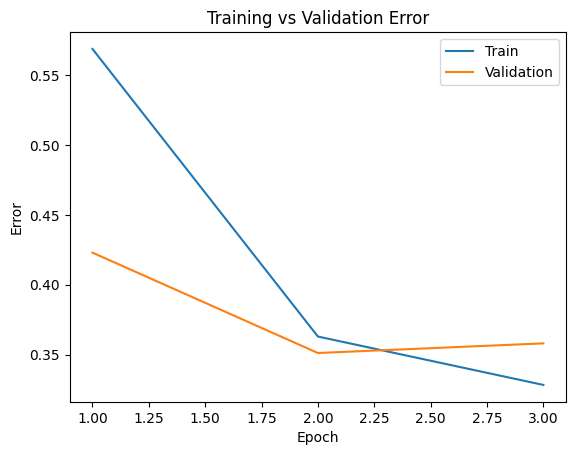

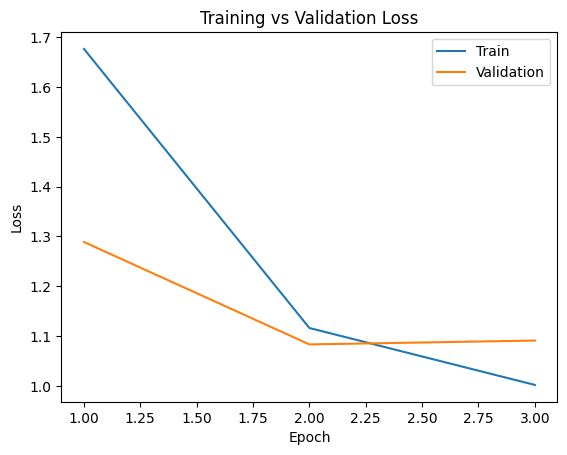

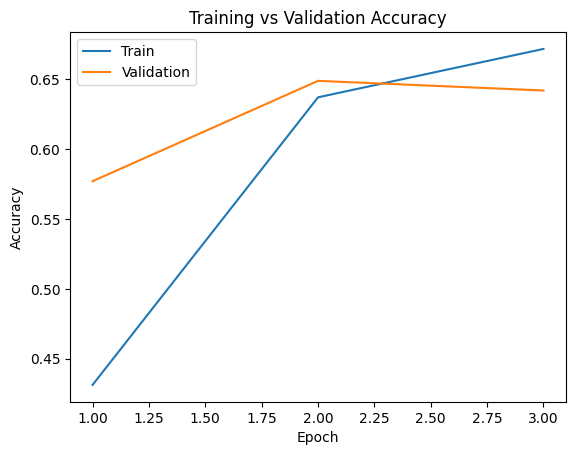

Validation Accuracy of this model is 0.6419540229885058
Testing Accuracy of this model is 0.6341743119266054


In [ ]:
Weather_net_Adam5 = WeatherNet()
train_loader_temp = DataLoader(train_dataset_aug, 64, shuffle=False)
train_net_Adam_Augmented(Weather_net_Adam5, 64, 8e-5, 3, order)
valid_loader_temp = DataLoader(valid_dataset_aug, 64, shuffle=False)
print("Validation Accuracy of this model is", get_accuracy(Weather_net_Adam5, valid_loader_temp))
test_loader_temp = DataLoader(test_dataset_aug, 1, shuffle=False)
print("Testing Accuracy of this model is", get_accuracy(Weather_net_Adam5, test_loader_temp))

Label is rain
Baseline output is hail
Neural Network model output is rain
------------------------------------------------
Label is rime
Baseline output is rime
Neural Network model output is rime
------------------------------------------------
Label is hail
Baseline output is hail
Neural Network model output is hail
------------------------------------------------
Label is frost
Baseline output is rime
Neural Network model output is rime
------------------------------------------------
Label is rime
Baseline output is rime
Neural Network model output is rime
------------------------------------------------


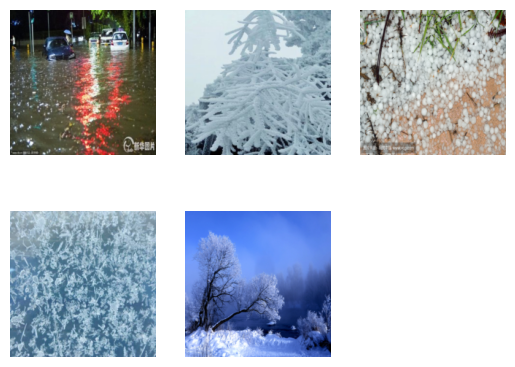

In [ ]:
data_used = test_loader_temp
base = base_ann
prev = -1
count = 0
size = 1
total_shown = 5
final_model = Weather_net_Adam5

for data, label in data_used:
    for i in range(size):
        plt.subplot(2, 3, count + 1)
        plt.axis('off')
        plt.imshow(data[i].permute(1, 2, 0))
        print("Label is", order[label[i]])
        output_bl = base(torch.FloatTensor(np.array(data[i])[np.newaxis, :, :, :]))
        prev = label[i]
        output_nn = final_model(torch.FloatTensor(np.array(data[i])[np.newaxis, :, :, :]))
        print("Baseline output is", order[int(output_bl.argmax(dim=1))])
        print("Neural Network model output is", order[int(output_nn.argmax(dim=1))])
        print("------------------------------------------------")
        count += 1
        if count == total_shown:
            break
    if count == total_shown:
        break

In [ ]:
all_classes = [glaze_data, lightning_data, rime_data]

for i in all_classes:
    correct = 0
    total = 0
    class_index = i[0][1]

    for image, label in i:
        output = final_model(image)
        correct += int(output.argmax(dim=1) == label)
        total += 1

    print("Accuracy of model over class", order[class_index], "is", float(correct/total))

Accuracy of model over class glaze is 0.8146551724137931
Accuracy of model over class lightning is 0.8594164456233422
Accuracy of model over class rime is 0.3395931142410016


In [ ]:
#optimal solution at num_epochs = 15 and learning_rate = 0.0001